In [1]:
import pandas as pd
import numpy as np

import os
import random

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
from PIL import Image
from tqdm import tqdm

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import nn, optim
from torchvision.transforms import AutoAugment, AutoAugmentPolicy
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights

from torch.optim.lr_scheduler import OneCycleLR


from sklearn.metrics import log_loss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [4]:
# !pip install ultralytics;

In [3]:
import shutil

shutil.copytree('/kaggle/input/hai-competition/train', '/kaggle/working/hai-competition/train')


'/kaggle/working/hai-competition/train'

In [6]:
train_root = '/kaggle/working/hai-competition/train'
test_root = '/kaggle/working/hai-competition/test'

In [2]:

def center_object_on_gray(img, mask):
    h, w, _ = img.shape
    mask = mask.astype(np.uint8)
    mask_3ch = np.stack([mask]*3, axis=-1)

    obj = img * mask_3ch

    y_indices, x_indices = np.where(mask > 0)
    if len(x_indices) == 0 or len(y_indices) == 0:
        return img 

    xmin, xmax = x_indices.min(), x_indices.max()
    ymin, ymax = y_indices.min(), y_indices.max()

    # crop object
    obj_crop = obj[ymin:ymax+1, xmin:xmax+1]

    canvas = np.ones_like(img, dtype=np.uint8) * 127
    h_crop, w_crop = obj_crop.shape[:2]

    x_offset = (w - w_crop) // 2
    y_offset = (h - h_crop) // 2

    canvas[y_offset:y_offset+h_crop, x_offset:x_offset+w_crop] = obj_crop

    return canvas

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from ultralytics import YOLO
from ultralytics.utils import LOGGER
import logging

LOGGER.setLevel(logging.WARNING)

model = YOLO("yolov8n-seg.pt")

input_root = '/kaggle/working/hai-competition/train'
output_root = '/kaggle/working/hai-competition/train_cleaned'
os.makedirs(output_root, exist_ok=True)


for cls_name in tqdm(os.listdir(input_root), desc="Processing classes"):
    cls_path = os.path.join(input_root, cls_name)
    if not os.path.isdir(cls_path): continue
    save_cls_path = os.path.join(output_root, cls_name)
    os.makedirs(save_cls_path, exist_ok=True)

    for fname in os.listdir(cls_path):
        if not fname.lower().endswith(('.jpg', '.jpeg', '.png')): continue

        img_path = os.path.join(cls_path, fname)
        img = cv2.imread(img_path)
        results = model(img)

        save_path = os.path.join(save_cls_path, fname)

        if results[0].masks is None or results[0].boxes is None: 
            cv2.imwrite(save_path, img)
            continue

        boxes = results[0].boxes.xyxy.cpu().numpy()
        masks = results[0].masks.data 
        
        if len(boxes) == 0:
            print("Not detected", img_path)
            cv2.imwrite(save_path, img)
            continue

        areas = [(box[2] - box[0]) * (box[3] - box[1]) for box in boxes]
        top_idx = np.argmax(areas) 
    
        mask = masks[top_idx].cpu().numpy()
        mask = (mask > 0.5).astype(np.uint8)
        mask = cv2.resize(mask, (img.shape[1], img.shape[0]))
        mask_3ch = np.stack([mask] * 3, axis=-1)
    
        
        gray_bg = np.ones_like(img, dtype=np.uint8) * 127
        masked_img = center_object_on_gray(img, mask)
        cv2.imwrite(save_path, masked_img)

    

🚗 Processing classes:  50%|█████     | 198/396 [05:47<05:47,  1.76s/it]

/tmp/ipykernel_112/814273740.py:22: UserWarning: Glyph 53364 (\N{HANGUL SYLLABLE KEUL}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_112/814273740.py:22: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_112/814273740.py:22: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  plt.tight_layout()


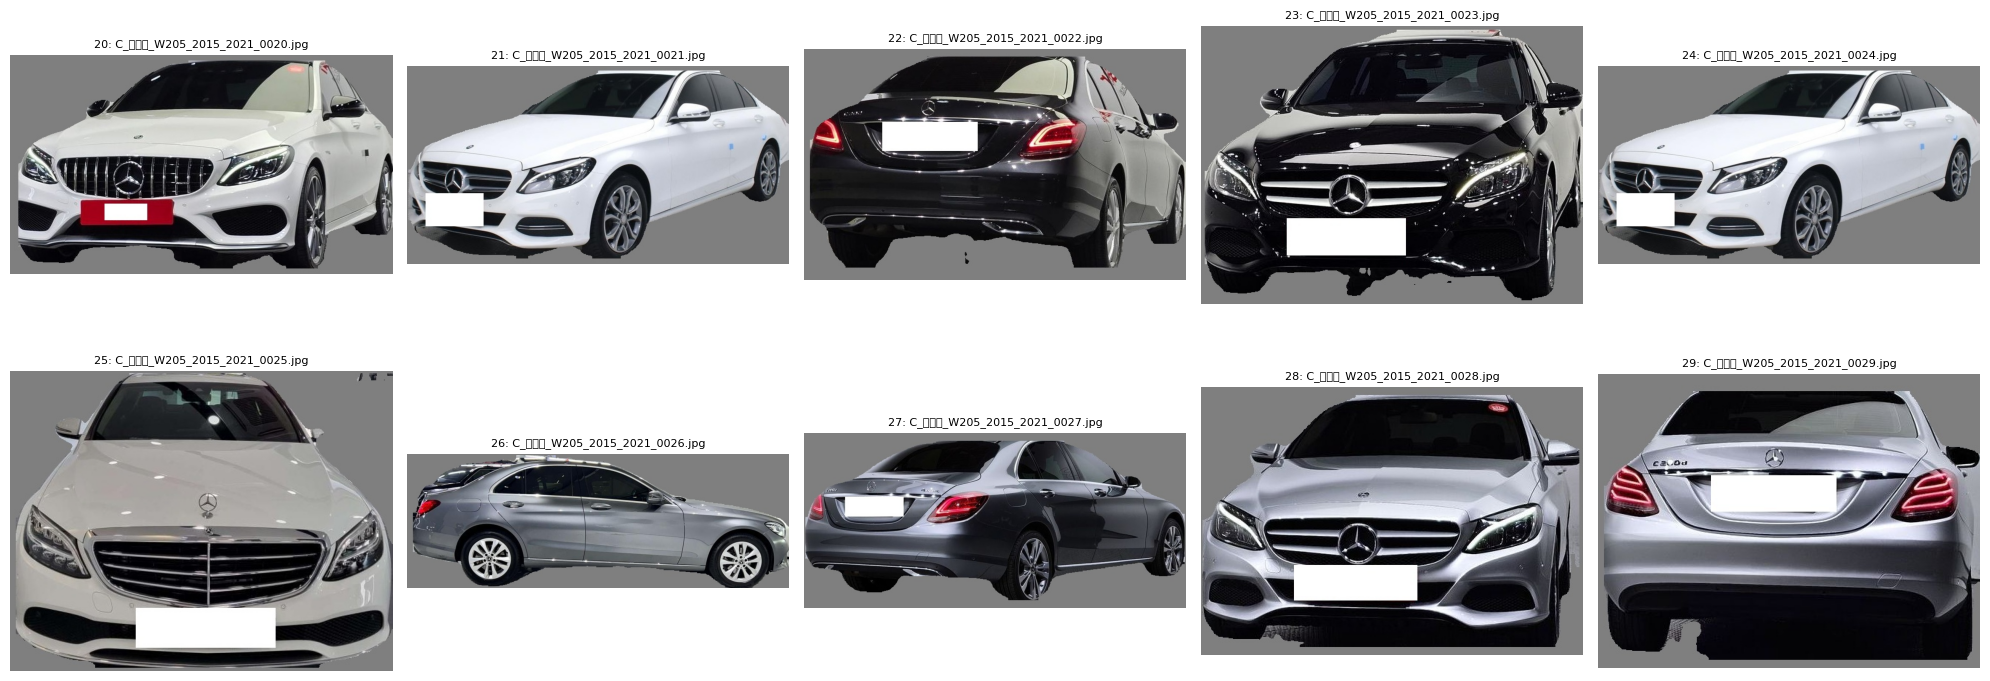

In [10]:
import os
import cv2
import matplotlib.pyplot as plt

def show_images_from_folder(folder_path, start_idx=0, n_images=10):
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    image_files = sorted(image_files) 

    selected_files = image_files[start_idx : start_idx + n_images]

    plt.figure(figsize=(20, 8))
    for i, fname in enumerate(selected_files):
        img_path = os.path.join(folder_path, fname)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.title(f"{start_idx + i}: {fname}", fontsize=8)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_images_from_folder('/kaggle/working/hai-competition/train_cleaned/C_클래스_W205_2015_2021', start_idx=20, n_images=10)
